### CIS 9650 - BRAIN STROKE ANALYSIS

In [347]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import percentile
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score, classification_report
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import liftChart, gainsChart
import warnings
warnings.filterwarnings("ignore")

In [348]:
##loading the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Data Pre-Processing

### 1) Null Values, Duplicates, and unique Rows

In [350]:
## Missing values
print(df.isnull().sum())
print("\n")

##Duplicates
duplicate = df[df.duplicated()]
print("Duplicate Rows:")

# There are 201 missing values on bmi column but no duplicates in the dataset

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Duplicate Rows:


In [351]:
## we will handle the missing values in bmi column using using mean() imputation
##because we want to preserve the sample size
df["bmi"].fillna(df["bmi"].mean(),inplace=True)

In [352]:
##print out columns and number of unique values
for col in df.columns:
    print(col, df[col].nunique())

id 5110
gender 3
age 104
hypertension 2
heart_disease 2
ever_married 2
work_type 5
Residence_type 2
avg_glucose_level 3979
bmi 419
smoking_status 4
stroke 2


In [353]:
print(df["gender"].value_counts())
## we see that there is only 1 row with gender=other, so we drop it out
df.drop(df.index[df["gender"]=="Other"], inplace=True)

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


In [354]:
##work type children also never worked
df[df["work_type"] == "children"]

#we replace children value with never worked
df["work_type"] = df["work_type"].replace(["children"], "Never_worked")

In [355]:
##next we will rename the residence_type for consistency
##and change age column into integer from float, then define categorical variables
df.rename(columns = {"Residence_type": "residence_type"}, inplace=True)
df["age"] = df["age"].astype("int")

cols = ["stroke", "gender", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status"]
df[cols] = df[cols].astype("category")

##we also drop id column as it doesn't contribute into our analysis
df.drop(["id"], axis="columns", inplace=True)


In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             5109 non-null   category
 1   age                5109 non-null   int64   
 2   hypertension       5109 non-null   category
 3   heart_disease      5109 non-null   category
 4   ever_married       5109 non-null   category
 5   work_type          5109 non-null   category
 6   residence_type     5109 non-null   category
 7   avg_glucose_level  5109 non-null   float64 
 8   bmi                5109 non-null   float64 
 9   smoking_status     5109 non-null   category
 10  stroke             5109 non-null   category
dtypes: category(8), float64(2), int64(1)
memory usage: 200.7 KB


### 2)Frequency of target variable

In [357]:
# "stroke" is the target variable in our dataset. Stroke=1 means a patient had a stroke 
# Frequency of the target variable
print(df["stroke"].value_counts())
#249 out of 5109 patients had a stroke

0    4860
1     249
Name: stroke, dtype: int64


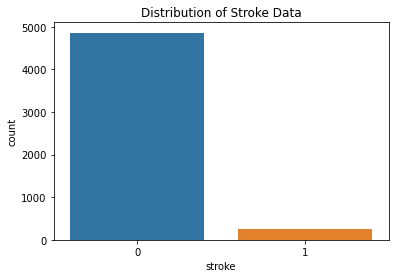

In [358]:
sns.countplot(x="stroke", data=df)
plt.title("Distribution of Stroke Data")
plt.show()
##our data is very unbalanced, we will work on this when modelling

## Exploratory Data Analysis

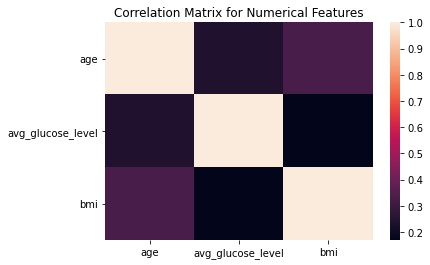

                    age  avg_glucose_level   bmi
age                1.00               0.24  0.33
avg_glucose_level  0.24               1.00  0.17
bmi                0.33               0.17  1.00


In [359]:
corr_matrix = df.corr().round(2)
sns.heatmap(corr_matrix)
plt.title("Correlation Matrix for Numerical Features")
plt.show()
print(corr_matrix)

##none of them seems to be highly correlated 

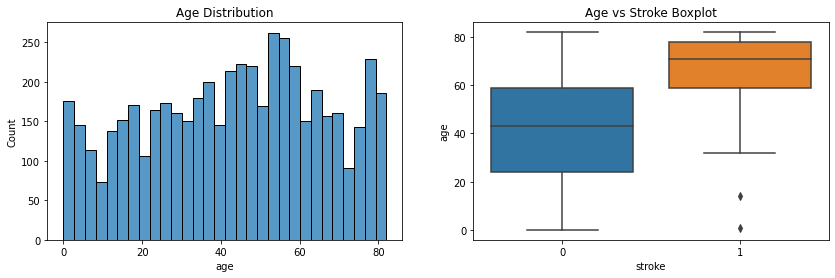

In [360]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["age"], data=df, bins=30, ax=axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(y=df["age"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("Age vs Stroke Boxplot")
plt.show()

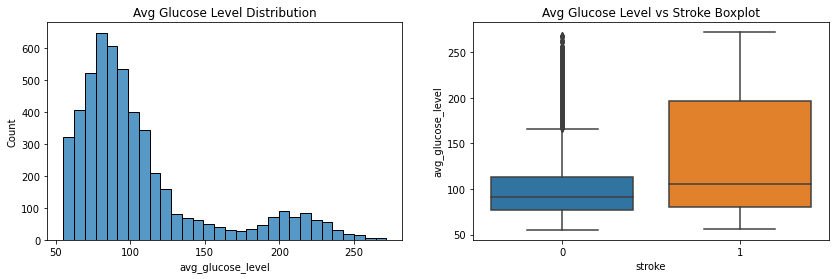

In [361]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["avg_glucose_level"], data=df, bins=30, ax=axes[0])
axes[0].set_title("Avg Glucose Level Distribution")

sns.boxplot(y=df["avg_glucose_level"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("Avg Glucose Level vs Stroke Boxplot")
plt.show()

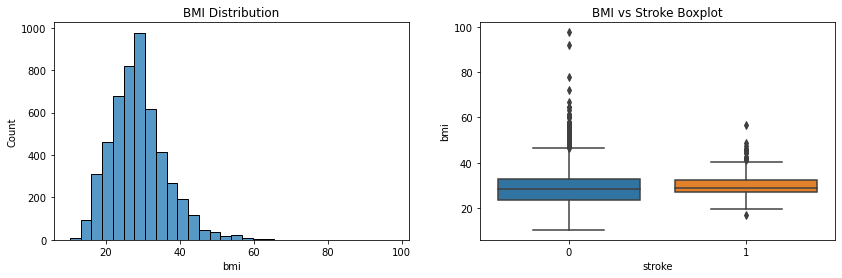

In [362]:
fig, axes = plt.subplots(1,2, figsize=(14,4))

sns.histplot(x=df["bmi"], data=df, bins=30, ax=axes[0])
axes[0].set_title("BMI Distribution")

sns.boxplot(y=df["bmi"], x="stroke", data=df, ax=axes[1])
axes[1].set_title("BMI vs Stroke Boxplot")
plt.show()

### Observations of Categorial Features

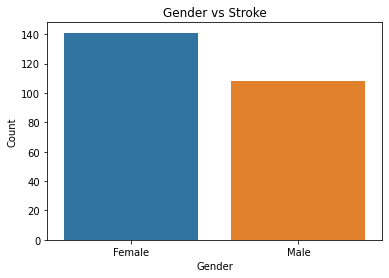

In [363]:
stroke1 = df.loc[df["stroke"] == 1]

##gender vs stroke
sns.countplot(x="gender", data=stroke1)
plt.title("Gender vs Stroke")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

##females are more likely to get a stroke than males

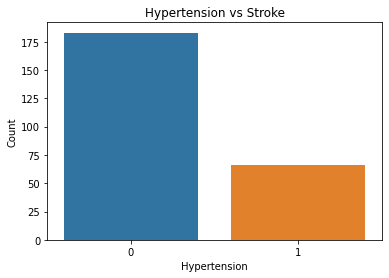

In [364]:
##hypertension vs stroke
sns.countplot(x="hypertension", data=stroke1)
plt.title("Hypertension vs Stroke")
plt.xlabel("Hypertension")
plt.ylabel("Count")
plt.show()

##not many people with hypertension had a stroke

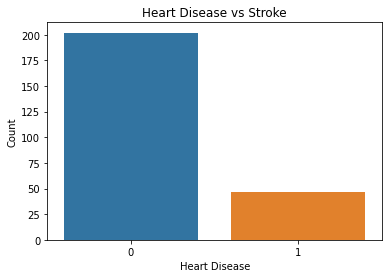

In [365]:
##heart disease vs stroke
sns.countplot(x="heart_disease", data=stroke1)
plt.title("Heart Disease vs Stroke")
plt.xlabel("Heart Disease")
plt.ylabel("Count")
plt.show()

##not many people with heart disease had a stroke

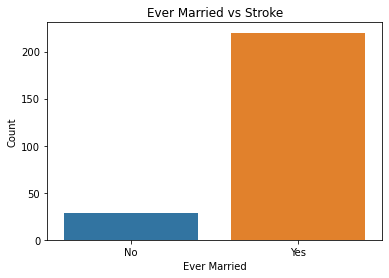

In [366]:
##ever_married vs stroke
sns.countplot(x="ever_married", data=stroke1)
plt.title("Ever Married vs Stroke")
plt.xlabel("Ever Married")
plt.ylabel("Count")
plt.show()

#### People who had a marriage or married more likely to get a stroke than others

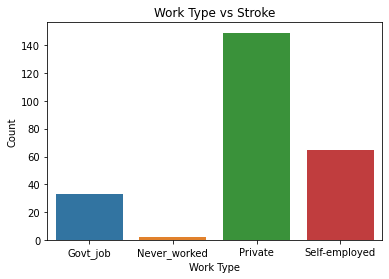

In [367]:
##work_type vs stroke
sns.countplot(x="work_type", data=stroke1)
plt.title("Work Type vs Stroke")
plt.xlabel("Work Type")
plt.ylabel("Count")
plt.show()

##people working in private sector more likely to get a stroke

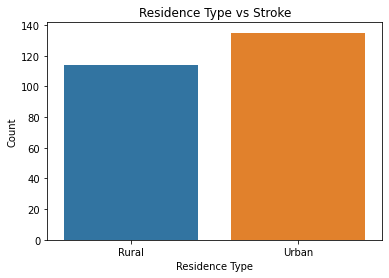

In [368]:
##residence_type vs stroke
sns.countplot(x="residence_type", data=stroke1)
plt.title("Residence Type vs Stroke")
plt.xlabel("Residence Type")
plt.ylabel("Count")
plt.show()

##residence type doesn't seem to have much effect on stroke

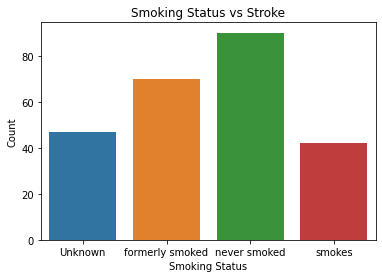

In [369]:
##smoking_status vs stroke
sns.countplot(x="smoking_status", data=stroke1)
plt.title("Smoking Status vs Stroke")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.show()

##smoking status doesn't seem to have any effect on stroke

### Removing Outliers

In [370]:
##Counting outliers in each numerical column
quant_var = ["bmi", "age", "avg_glucose_level"]
outlier_count = []
print("Number of outliers in each column are as follows: ","\n")

for i in quant_var:
    ##calculate interquartile range
    q25 = np.percentile(df[i], 25)
    q75 = np.percentile(df[i], 75)
    iqr = q75 - q25
    
    ##calculate lower and upper limits
    low_lim = q25 - (1.5 * iqr)
    up_lim = q75 + (1.5 * iqr)
    lst = df[(df[i] < low_lim) | (df[i] > up_lim)].index
    outlier_count.append(len(lst))
    print(i + " ", len(lst))

print("\n","Total outlier count:", sum(outlier_count))

Number of outliers in each column are as follows:  

bmi  126
age  0
avg_glucose_level  627

 Total outlier count: 753


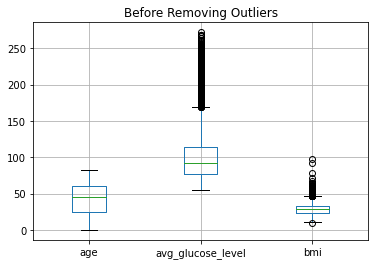

In [371]:
df.boxplot()
plt.title("Before Removing Outliers")
plt.show()

In [372]:
##creating a function to remove outliers
def remove_outliers(data):
    ##calculate interquartile range
    q25 = np.percentile(data, 25)
    q75 = np.percentile(data, 75)
    iqr = q75 - q25
    
    ##calculate lower and upper limits
    low_lim = q25 - (1.5 * iqr)
    up_lim = q75 + (1.5 * iqr)
    
    ##identify and remove outliers
    outliers = []
    for x in data:
        if x < low_lim:
            x = low_lim
            outliers.append(x)
        elif x > up_lim:
            x = up_lim
            outliers.append(x)
        else:
            outliers.append(x)
    return outliers

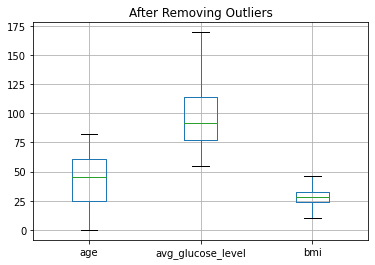

In [373]:
##removing outliers
df["bmi"] = remove_outliers(df['bmi'])
df["avg_glucose_level"] = remove_outliers(df["avg_glucose_level"])

df.boxplot()
plt.title("After Removing Outliers")
plt.show()

### Encoding

In [374]:
##Encoding
##get dummies and identify predictor and outcome variables
predictors = df.drop(columns = ["stroke"])
outcome = "stroke"

X = pd.get_dummies(predictors, drop_first=True)
y = df[outcome]

##Split validation
train_X, valid_X, train_y, valid_y= train_test_split(X, y, test_size=0.20, random_state=1)

### OverSampling

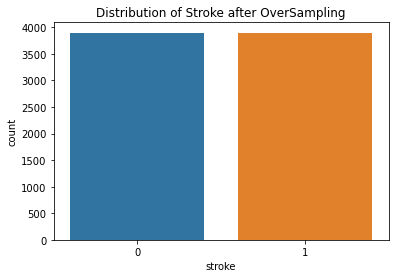

In [375]:
##Oversampling
smote = SMOTE()
train_X, train_y = smote.fit_resample(train_X, train_y)

###distribution of target variable after oversampling
sns.countplot(x = train_y, data = df)
plt.title("Distribution of Stroke after OverSampling")
plt.show()

## Comparison of Baseline Models with OverSampling

### 1) Decision Trees

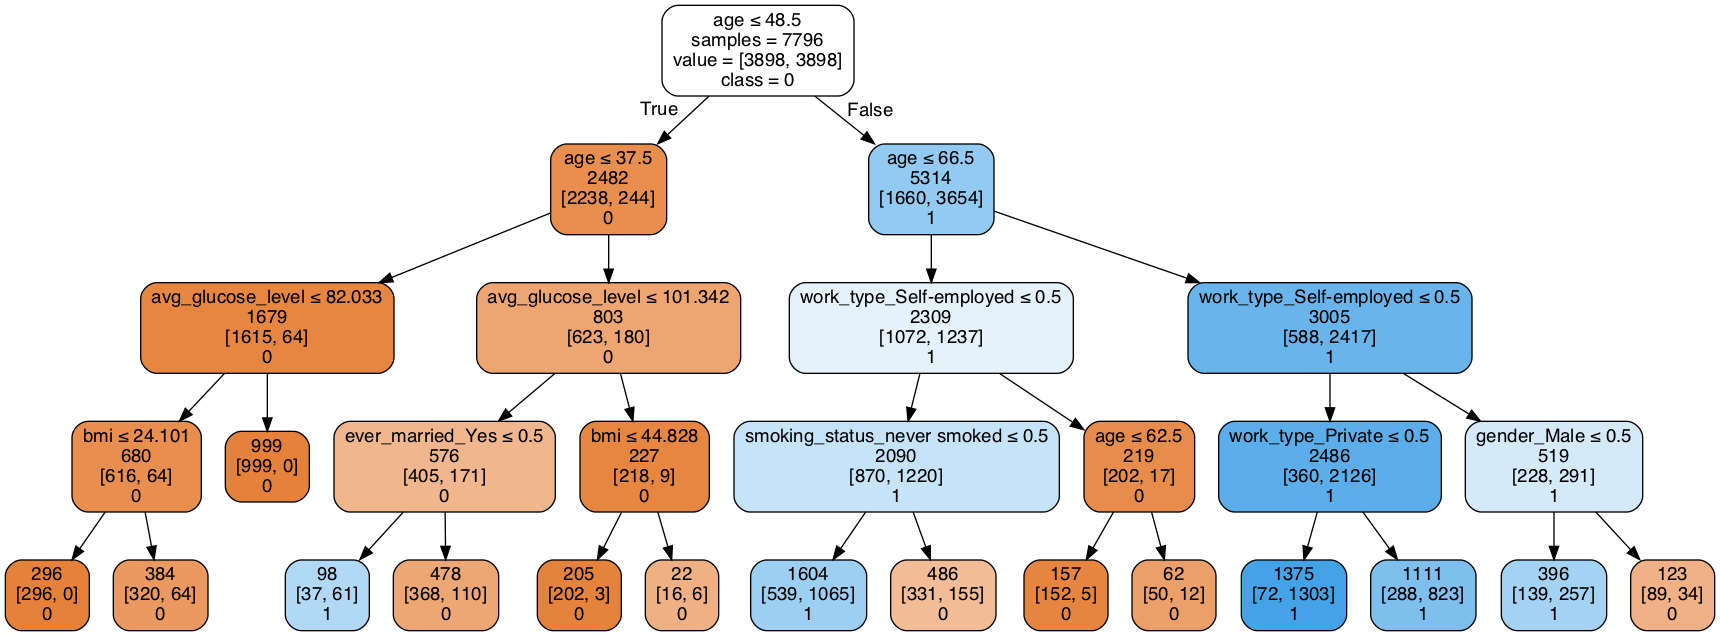

In [376]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(train_X, train_y)
plotDecisionTree(dt, feature_names=train_X.columns, class_names=dt.classes_)

In [377]:
##Get the prediction for both train and test
prediction_train_dt = dt.predict(train_X)
prediction_valid_dt = dt.predict(valid_X)

##Measure the accuracy of the model for both train and test sets
print("Accuracy on training set is:",round(accuracy_score(train_y, prediction_train_dt),2))
print("Accuracy on test set is:",round(accuracy_score(valid_y, prediction_valid_dt ),2))

Accuracy on training set is: 0.81
Accuracy on test set is: 0.73


In [378]:
##Calculating precision, recall and F-measure
p1=round(precision_score(valid_y,prediction_valid_dt),3)
r1=round(recall_score(valid_y,prediction_valid_dt),3)
f1_1=round(f1_score(valid_y,prediction_valid_dt),3)
a1=round(accuracy_score(valid_y, prediction_valid_dt),3)

print("Scores for prediction on validation set")
print("Precision score: ", p1)
print("Recall score: ", r1)
print("f1-score: ", f1_1)
print("Accuracy:",a1)

Scores for prediction on validation set
Precision score:  0.151
Recall score:  0.783
f1-score:  0.253
Accuracy: 0.729


### 2) Logistics Regression

In [379]:
##build the logistic regression model logit_reg
logit=LogisticRegression(solver='liblinear')
logit.fit(train_X,train_y)

##Predictions on training and validation set
prediction_train_log = logit.predict(train_X)
prediction_valid_log = logit.predict(valid_X)
print("Accuracy on train is:",round(accuracy_score(train_y,prediction_train_log),2))
print("Accuracy on test is:",round(accuracy_score(valid_y,prediction_valid_log),2))

Accuracy on train is: 0.86
Accuracy on test is: 0.84


In [380]:
##Calculating precision, recall and F-measure

p2=round(precision_score(valid_y,prediction_valid_log),2)
r2=round(recall_score(valid_y,prediction_valid_log),2)
f1_2=round(f1_score(valid_y,prediction_valid_log),2)
a2=round(accuracy_score(valid_y, prediction_valid_log),2)

print("Scores for prediction on validation set:")
print("Precision score: ", p2)
print("Recall score: ", r2)
print("f1-score: ", f1_2)
print("Accuracy:",a2)

Scores for prediction on validation set:
Precision score:  0.15
Recall score:  0.4
f1-score:  0.22
Accuracy: 0.84


### 3) Naive Bayes Model

In [381]:
##run naive Bayes
nb = GaussianNB()
nb.fit(train_X,train_y)

##predict class membership
prediction_train_nb=nb.predict(valid_X)

##predict probabilities
pred_train_prob_nb = nb.predict_proba(valid_X)

##Prediction accuracy on training and validation set
prediction_train_nb = nb.predict(train_X)
prediction_valid_nb = nb.predict(valid_X)
print("Accuracy on train is:",accuracy_score(train_y,prediction_train_nb))
print("Accuracy on test is:",accuracy_score(valid_y,prediction_valid_nb))

Accuracy on train is: 0.7968188814776809
Accuracy on test is: 0.6555772994129159


In [382]:
##Calculating precision, recall and F-measure on valid

p3=precision_score(valid_y,prediction_valid_nb)
r3=recall_score(valid_y,prediction_valid_nb)
f1_3=f1_score(valid_y,prediction_valid_nb)
a3=accuracy_score(valid_y, prediction_valid_nb)

print("Precision score: ", p3)
print("Recall score: ", r3)
print("f1-score: ", f1_3)
print("Accuracy:",a3)

Precision score:  0.0989010989010989
Recall score:  0.6
f1-score:  0.16981132075471697
Accuracy: 0.6555772994129159


### 4) Random Forest

In [383]:
rf=RandomForestClassifier(criterion = 'entropy', random_state = 42, n_estimators=500)
rf.fit(train_X,train_y)
##Model evaluation on training set
print("Accuracy with training set:",accuracy_score(train_y, rf.predict(train_X)))
##Model evaluation on validation set
print("Accuracy with validation set:",accuracy_score(valid_y, rf.predict(valid_X)))

Accuracy with training set: 1.0
Accuracy with validation set: 0.9031311154598826


In [384]:
p4= precision_score(valid_y,rf.predict(valid_X))
r4= recall_score(valid_y,rf.predict(valid_X))
f1_4=f1_score(valid_y,rf.predict(valid_X))
a4=accuracy_score(valid_y, rf.predict(valid_X))
print("precision score: ", p4)
print("recall score: ", r4)
print("f1-score: ", f1_4)
print("Accuracy:", a4)

precision score:  0.10204081632653061
recall score:  0.08333333333333333
f1-score:  0.09174311926605504
Accuracy: 0.9031311154598826


In [385]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                           index = train_X.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
age,0.326749
bmi,0.162781
avg_glucose_level,0.156853
smoking_status_never smoked,0.056433
smoking_status_smokes,0.039190
work_type_Private,0.038712
smoking_status_formerly smoked,0.038332
gender_Male,0.036844
work_type_Self-employed,0.034240
residence_type_Urban,0.028896


In [386]:
# Creating lists of all scores for comparison
p=[p1,p2,p3,p4]
r=[r1,r2,r3,r4]
f=[f1_1,f1_2,f1_3,f1_4]
acc=[a1,a2,a3,a4,]

# Dataframe for comparison
df_metrics=pd.DataFrame({"Classifier":["Decision Tree Classifier","Logistic Regression","Naive Bayes","Random Forest",],"Precision":p,"Recall":r,"F score":f,"Accuracy":acc})
df_metrics

,Classifier,Precision,Recall,F score,Accuracy
0,Decision Tree Classifier,0.151000,0.783000,0.253000,0.729000
1,Logistic Regression,0.150000,0.400000,0.220000,0.840000
2,Naive Bayes,0.098901,0.600000,0.169811,0.655577
3,Random Forest,0.102041,0.083333,0.091743,0.903131


## NAIVE BAYES WITH FEATURE ENGINEERING

In [387]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [388]:
forward_selection(X,y)

['age',
 'work_type_Never_worked',
 'heart_disease_1',
 'avg_glucose_level',
 'ever_married_Yes',
 'hypertension_1',
 'work_type_Private']

In [389]:
X_for_selected=X[['age',
 'work_type_Never_worked',
 'heart_disease_1',
 'avg_glucose_level',
 'ever_married_Yes',
 'hypertension_1',
 'work_type_Private']]

# splitting the dataset
trainx, validx, trainy, validy= train_test_split(X_for_selected,y,test_size=0.30, random_state=1)

##run naive Bayes
nb = GaussianNB()
nb.fit(trainx,trainy)

##predict class membership
prediction_train_nb=nb.predict(validx)

##predict probabilities
pred_train_prob_nb = nb.predict_proba(validx)

##Prediction accuracy on training and validation set

prediction_train_nb = nb.predict(trainx)
prediction_valid_nb = nb.predict(validx)
print("Accuracy on train is:", accuracy_score(trainy,prediction_train_nb))
print("Accuracy on test is:", accuracy_score(validy,prediction_valid_nb))

Accuracy on train is: 0.860178970917226
Accuracy on test is: 0.8617090671885193


In [390]:
##Calculating precision, recall and F-measure on valid

p3=precision_score(validy,prediction_valid_nb)
r3=recall_score(validy,prediction_valid_nb)
f1_3=f1_score(validy,prediction_valid_nb)
a3=accuracy_score(validy, prediction_valid_nb)

print("Precision score: ", p3)
print("Recall score: ", r3)
print("f1-score: ", f1_3)
print("Accuracy:",a3)

Precision score:  0.19138755980861244
Recall score:  0.4819277108433735
f1-score:  0.273972602739726
Accuracy: 0.8617090671885193


#### At last, we increased our accuracy and f1score with feature engineering.Next focusing on following variables, we will write our program to predict if someone will have stroke or not.
['age',
 'work_type_Never_Worked',
 'heart_disease_1',
 'avg_glucose_level',
 'ever_married_Yes',
 'hypertension_1',
 'work_type_Private']